<a href="https://colab.research.google.com/github/gustavovazquez/ML/blob/main/MCD_UCU_Series_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción
Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

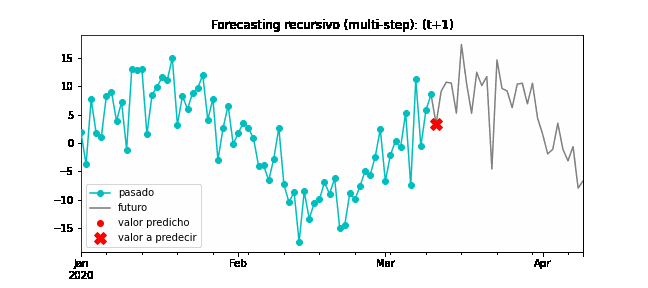

#Entrenamiento de un modelo de forecasting
La principal adaptación que se necesita hacer para aplicar modelos de machine learning a problemas de forecasting es transformar la serie temporal en un matriz en la que cada valor está asociado a la ventana temporal (lags) que le precede.

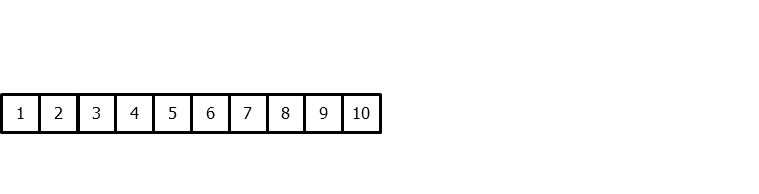

Este tipo de transformación también permite incluir variables exógenas a la serie temporal.
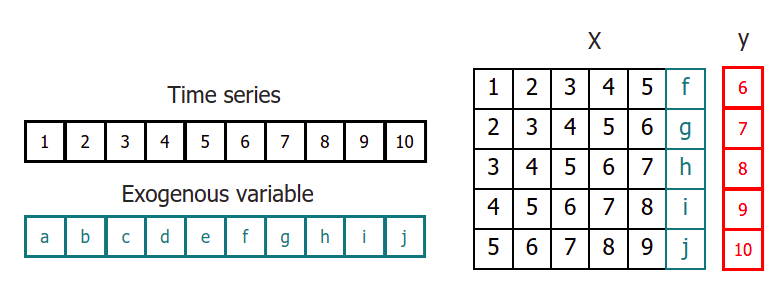

Una vez que los datos se encuentran reordenados de esta forma, se puede entrenar cualquier modelo de regresión para que aprenda a predecir el siguiente valor de la serie.

# Predicciones multi-step
Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie $({t+1})$, sino todo un intervalo futuro o un punto alejado en el tiempo $({t+n})$. A cada paso de predicción se le conoce como step. Existen varias estrategias que permiten generar este tipo de predicciones múltiples.

## Recursive multi-step forecasting
Dado que, para predecir el momento $t_n$ se necesita el valor de $t_{n-1}$
 , y  $t_{n-1}$ se desconoce, se sigue un proceso recursivo en el que, cada nueva predicción, hace uso de la predicción anterior. A este proceso se le conoce como recursive forecasting o recursive multi-step forecasting y pueden generarse fácilmente con las clases ```ForecasterAutoreg``` y ```ForecasterAutoregCustom``` de la librería ```skforecast```
 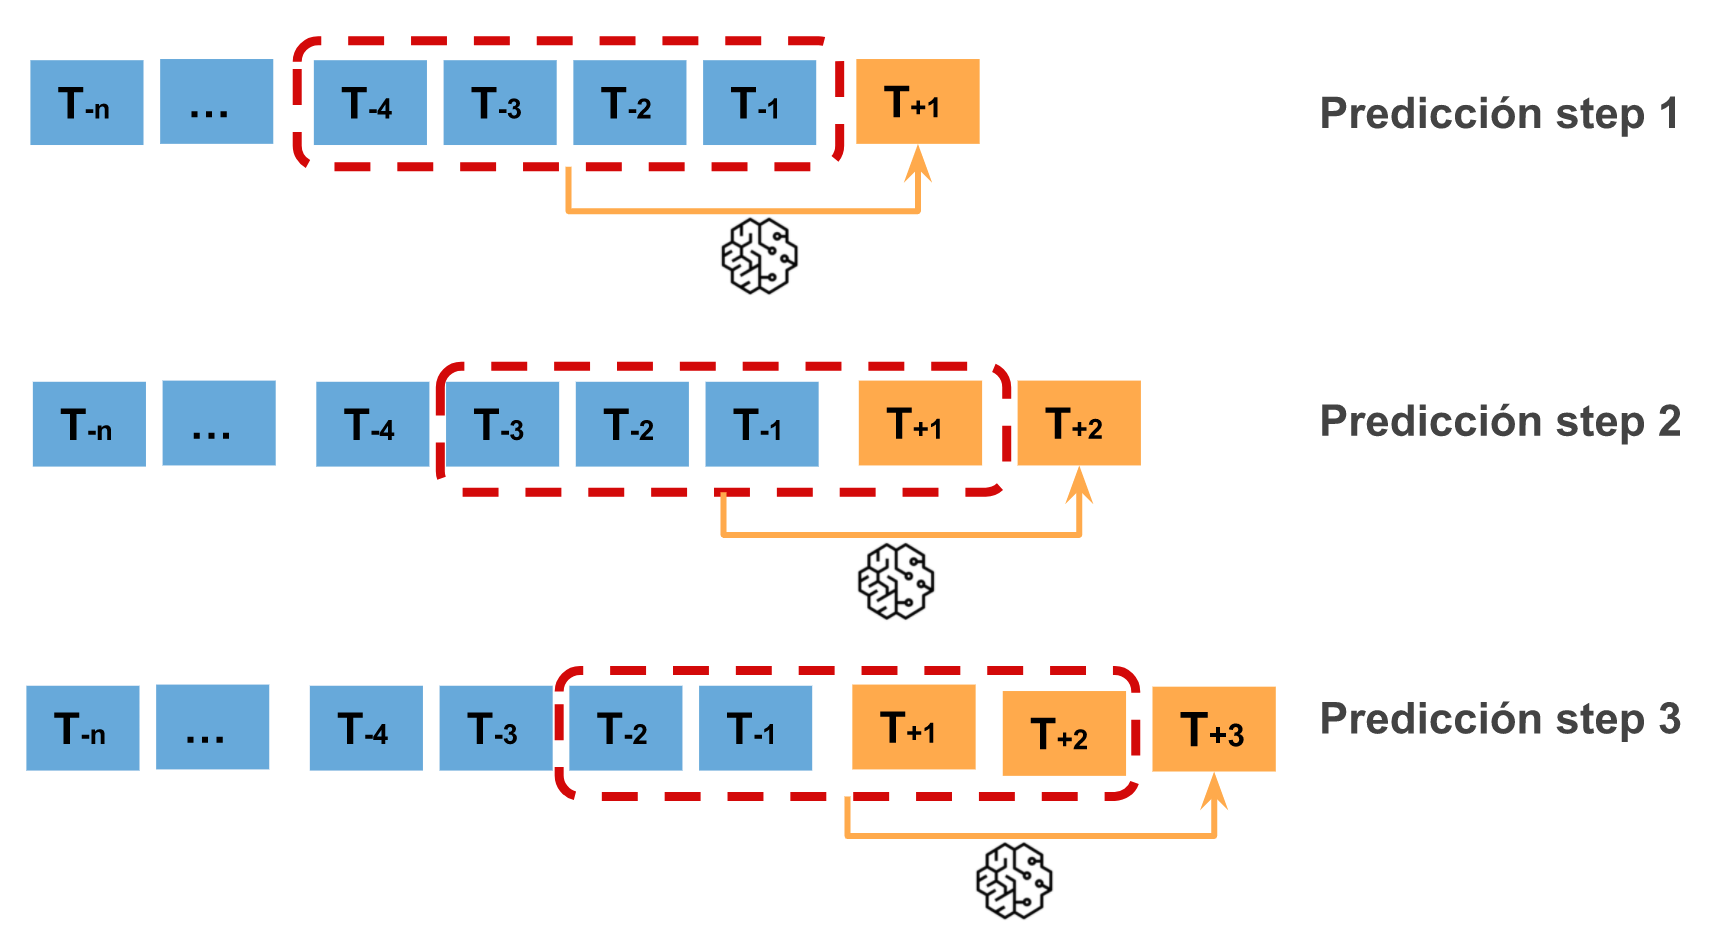

## Direct multi-step forecasting
El método direct multi-step forecasting consiste en entrenar un modelo distinto para cada step. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada step. Como resultado, las predicciones son independientes unas de otras.
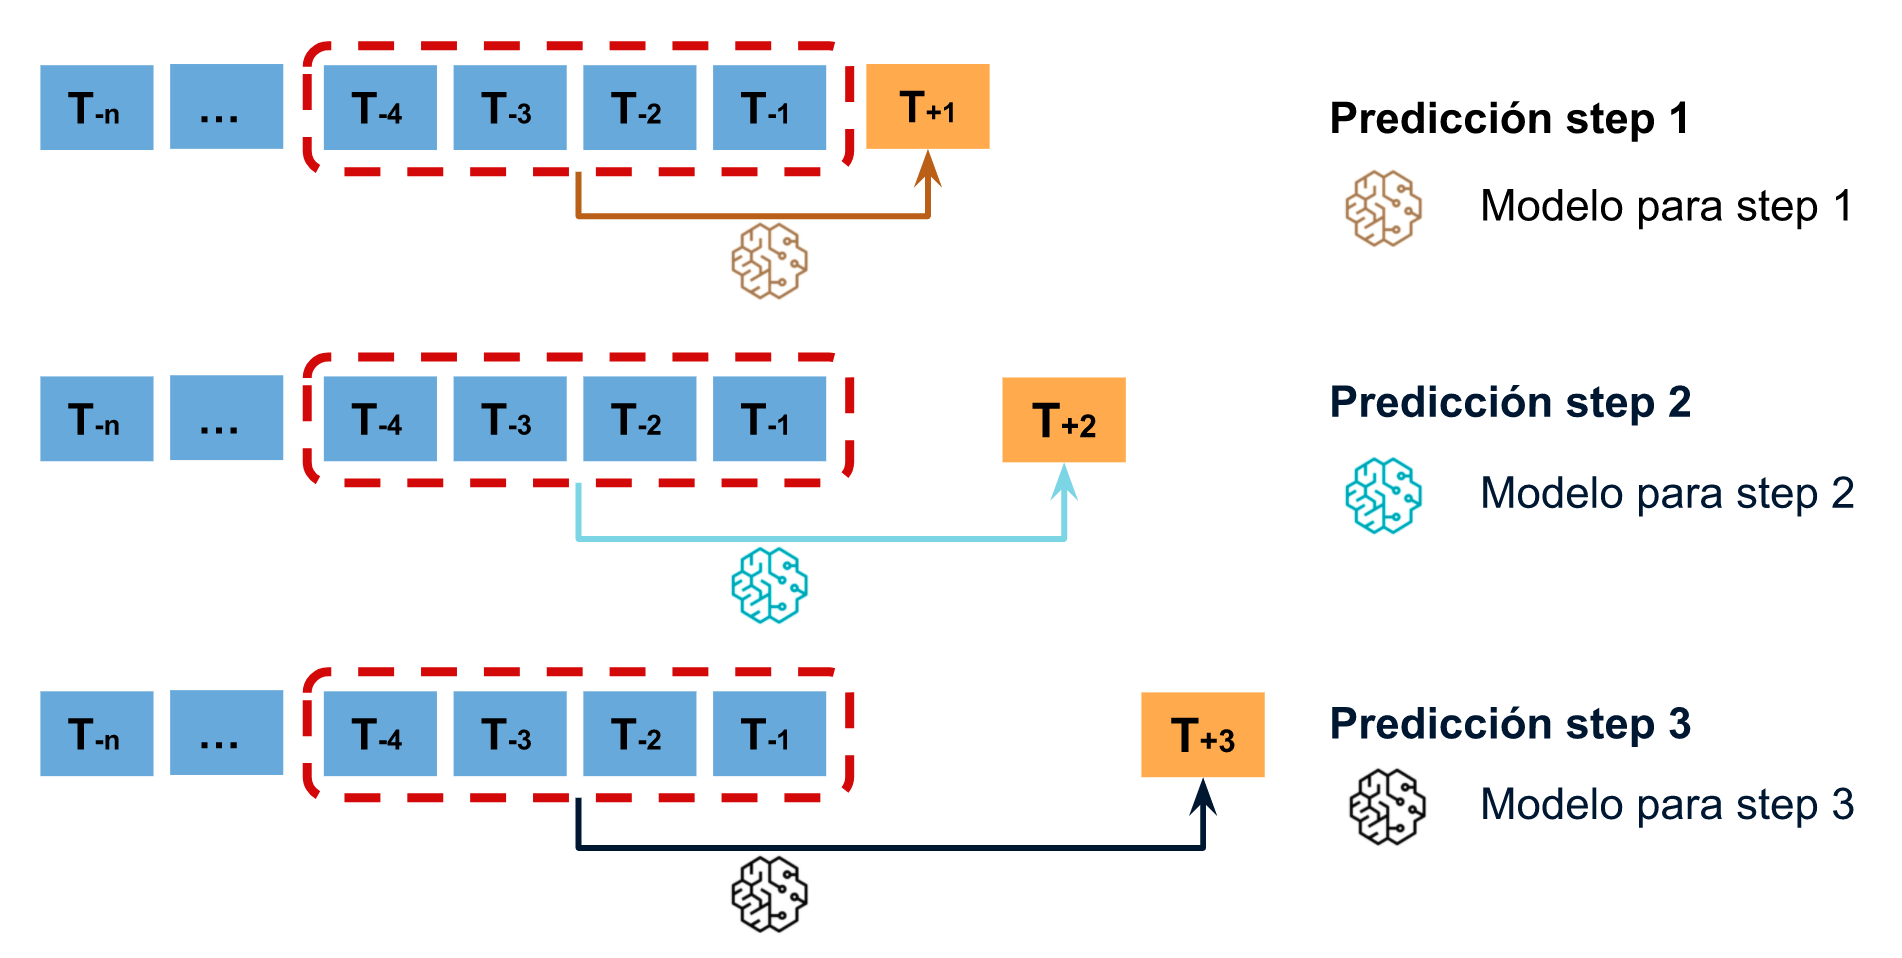

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelo. Todo este proceso está automatizado en la clase ```ForecasterAutoregDirect``` de la librería ```skforecast```. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos. En el siguiente esquema se muestra el proceso para un caso en el que se dispone de la variable respuesta y dos variables exógenas.
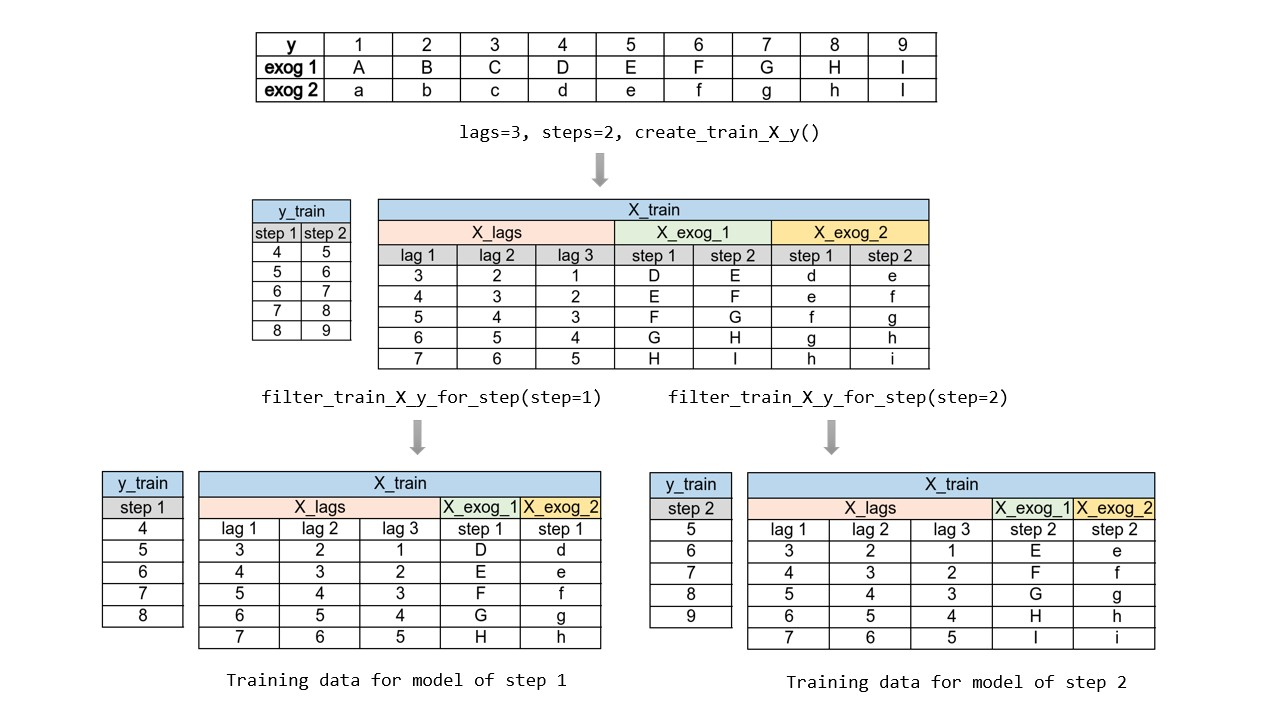

# Ejemplo

Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. Se pretende crear un modelo autoregresivo capaz de predecir el futuro gasto mensual.

Los datos empleados en los ejemplos de este documento se han obtenido del  libro Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos.

In [ ]:
!pip install skforecast==0.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.0 MB/s eta 0:00:00


In [ ]:

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# Descarga de datos
# ==============================================================================
#url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
url = 'https://raw.githubusercontent.com/gustavovazquez/datasets/main/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

La columna fecha se ha almacenado como string. Para convertirla en datetime, se emplea la función pd.to_datetime(). Una vez en formato datetime, y para hacer uso de las funcionalidades de Pandas, se establece como índice. Además, dado que los datos son mensuales, se indica la frecuencia (Monthly Started 'MS').

In [ ]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


Al establecer una frecuencia con el método asfreq(), Pandas completa los huecos que puedan existir en la serie temporal con el valor de Null con el fin de asegurar la frecuencia indicada. Por ello, se debe comprobar si han aparecido missing values tras esta transformación.

In [ ]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


Aunque no es necesario al haber establecido un frecuencia, se puede verificar que la serie temporal esté completa.

In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

np.True_

Se utilizan los últimos 36 meses como conjunto de test para evaluar la capacidad predictiva del modelo.

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


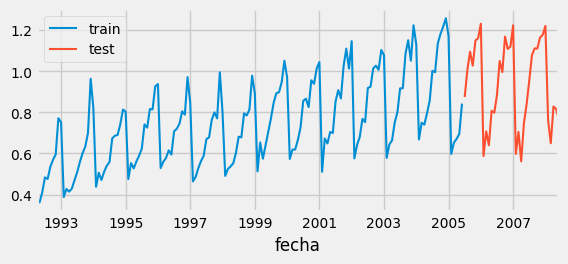

In [ ]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

# Forecasting autorregresivo recursivo
## ForecasterAutoreg
Se crea y entrena un modelo ForecasterAutoreg a partir de un regresor RandomForestRegressor y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-11-07 17:00:35 
Last fit date: 2025-11-07 17:00:35 
Skforecast version: 0.13.0 
Python version: 3.12.12 
Fo

## Predicciones
Una vez entrenado el modelo, se predicen los datos de test (36 meses a futuro).

In [ ]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

,pred
2005-07-01,0.878756
2005-08-01,0.882167
2005-09-01,0.973184
2005-10-01,0.983678
2005-11-01,0.849494


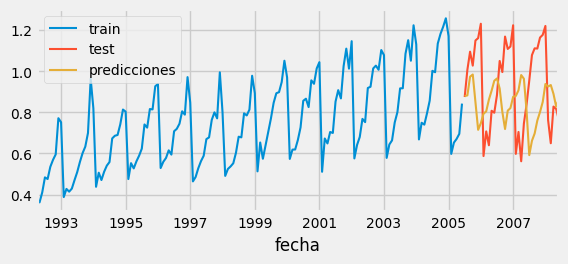

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

## Error de las predicciones en el conjunto de test
Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea como métrica el mean squared error (mse).

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.07326833976120374


In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                  )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.021992765856921042



## Ajuste de hiperparámetros (tuning)
El ForecasterAutoreg entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. La librería Skforecast dispone de la función grid_search_forecaster con la que comparar los resultados obtenidos con múltiples combinaciones de hiperparámetros y lags, e identificar la mejor.
El coste computacional del ajuste de hiperparámetros depende en gran medida del enfoque de backtesting elegido para evaluar cada combinación de hiperparámetros. En general, la duración del proceso de ajuste aumenta a medida que crece el número de reentrenamientos implicados en el backtesting. Para acelerar la fase de prototipado, es muy recomendable adoptar una estrategia en dos pasos. En primer lugar, utilizar refit=False durante la búsqueda inicial para reducir el rango de valores. A continuación, focalizarse en la región de interés identificada y aplicar una estrategia de backtesting que cumpla los requisitos específicos del caso de uso.

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.021993,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.022114,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.022224,10,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.022530,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.022569,3,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.023400,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.063144,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.064775,3,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.066307,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.067151,5,100


## Modelo final
Finalmente, se entrena de nuevo un ForecasterAutoreg con la configuración óptima encontrada mediante validación. Este paso no es necesario si se indica return_best = True en la función grid_search_forecaster.

In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['y'])

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

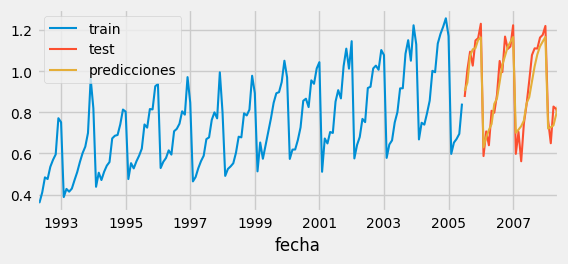

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.004392699665157793


Con la combinación óptima de hiperparámetros se consigue reducir notablemente el error de test.

## Backtesting
El proceso de backtesting consiste en evaluar el comportamiento de un modelo predictivo al aplicarlo de forma retrospectiva sobre datos históricos. Por lo tanto, es una estrategia de validación que permite cuantificar la capacidad predictiva de un modelo.

Para garantizar una evaluación precisa de su modelo y ganar confianza en su rendimiento predictivo con nuevos datos, es fundamental emplear una estrategia de backtesting adecuada. Factores como las características del caso de uso, los recursos informáticos disponibles y los intervalos de tiempo entre predicciones deben tenerse en cuenta para determinar qué estrategia utilizar. En términos generales, cuanto más se parezca el proceso de backtesting al escenario real en el que se utilizará el modelo, más fiable será la métrica estimada

### Backtesting con reentrenamiento

El modelo se entrena cada vez antes de realizar las predicciones, de esta forma, se incorpora toda la información disponible hasta el momento. Se trata de una adaptación del proceso de cross-validation en el que, en lugar de hacer un reparto aleatorio de las observaciones, el conjunto de entrenamiento se incrementa de manera secuencial, manteniendo el orden temporal de los datos.
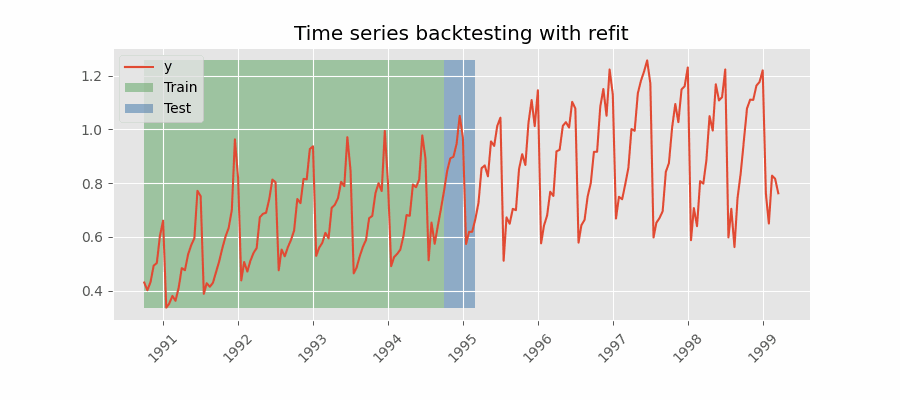

### Backtesting con reentrenamiento y tamaño de entrenamiento constante

Similar a la estrategia anterior, pero, en este caso, el tamaño del conjunto de entrenamiento no se incrementa sino que la ventana de tiempo que abarca se desplaza. Esta estrategia se conoce también como time series cross-validation o walk-forward validation.
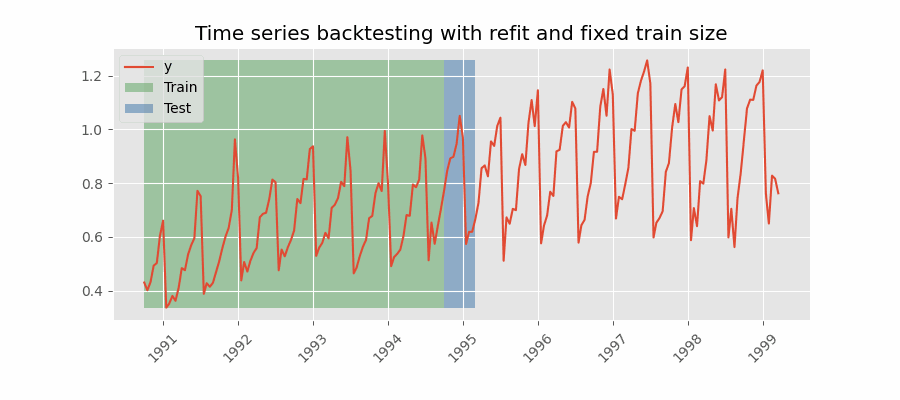


### Backtesting con reentrenamiento cada n periodos (intermitente)

El modelo se reentrena de forma intermitente cada  n
  periodos de predicción.
  Esta estrategia suele lograr un buen equilibrio entre el coste computacional del reentrenamiento y evitar la degradación del modelo.
  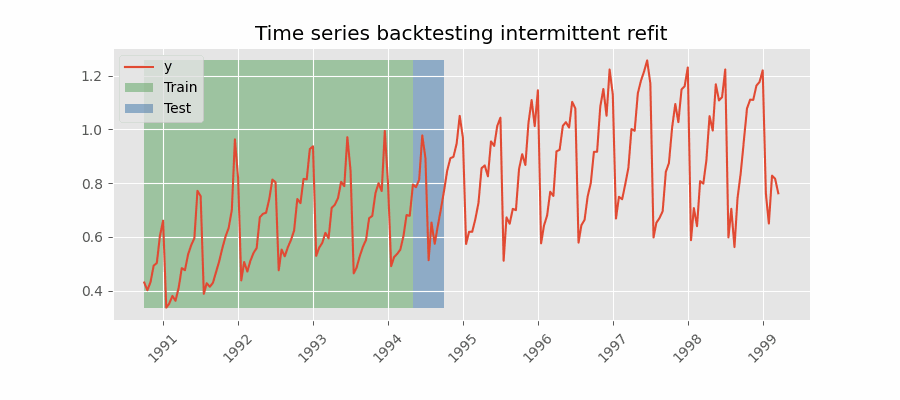

### Backtesting sin reentrenamiento

Con esta estrategia, el modelo se entrena una única vez con un conjunto inicial y se realizan las predicciones de forma secuencial sin actualizar el modelo y siguiendo el orden temporal de los datos. Esta estrategia tiene la ventaja de ser mucho más rápida puesto que el modelo solo se entrena una vez. La desventaja es que el modelo no incorpora la última información disponible por lo que puede perder capacidad predictiva con el tiempo.
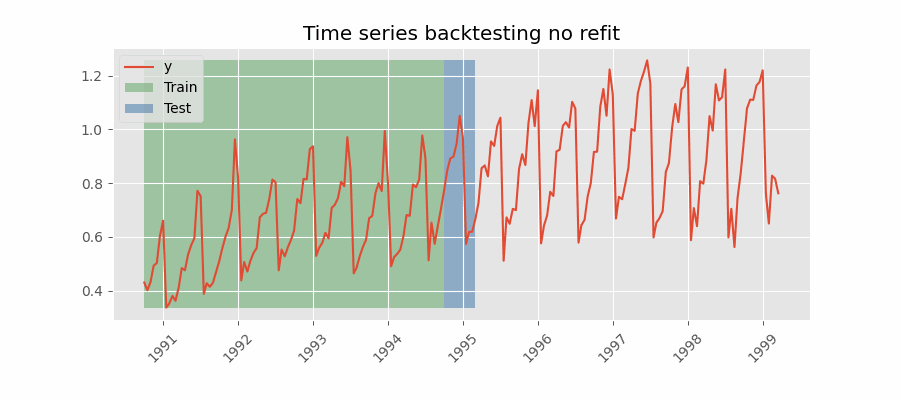

La librería ```skforecast``` dispone de múltiples estrategias de backtesting mencionadas. Independientemente de cuál se utilice, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de overfitting.

Para este ejemplo, se sigue una estrategia de backtesting con reentrenamiento. Internamente, el proceso seguido por la función es el siguiente:

- En la primera iteración, el modelo se entrena con las observaciones seleccionadas para el entrenamiento inicial (en este caso, 87). Después, las siguientes 36 observaciones se utilizan para validar las predicciones de este primer modelo (también 36).

- En la segunda iteración, se reentrena el modelo añadiendo, al conjunto de entrenamiento inicial, las 36 observaciones de validación anteriores (87 + 36). De la misma manera, se establece como nuevo conjunto de validación las 36 observaciones siguientes.

- Este proceso se repite hasta que se utilizan todas las observaciones disponibles. Siguiendo esta estrategia, el conjunto de entrenamiento aumenta en cada iteración con tantas observaciones como steps se estén prediciendo.

In [ ]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

Error de backtest:    mean_squared_error
0            0.010579


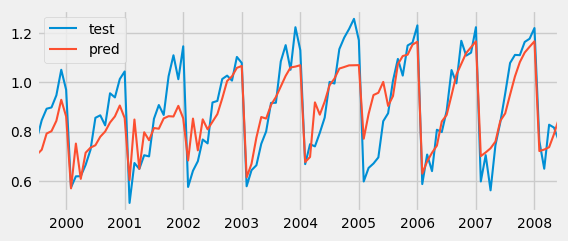

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

## Importancia predictores
Dado que el objeto ```ForecasterAutoreg``` utiliza modelos ```scikit-learn```, una vez entrenado, se puede acceder a la importancia de los predictores. Cuando el regresor empleado es un LinearRegression, Lasso o Ridge, la importancia queda reflejada en los coeficientes del modelo. En regresores como GradientBoostingRegressor, RandomForestRegressor o HistGradientBoostingRegressor, la importancia de los predictores está basada en la reducción de impureza.

get_feature_importances() solo devuelve valores si el regresor utilizado dentro del forecaster tiene el atributo coef_ o feature_importances_.

In [ ]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importances()
impotancia

,feature,importance
11,lag_12,0.816041
1,lag_2,0.087268
13,lag_14,0.019411
9,lag_10,0.013076
2,lag_3,0.012754
0,lag_1,0.009412
10,lag_11,0.008868
14,lag_15,0.008746
7,lag_8,0.006926
8,lag_9,0.005839


# Forecasting autorregresivo recursivo con variables exógenas
En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable predicha. En ciertos escenarios, es posible disponer de información sobre otras variables, cuyo valor a futuro se conoce, y pueden servir como predictoreres adicionales en el modelo.

Siguiendo con el ejemplo anterior, se simula una nueva variable cuyo comportamiento está correlacionado con la serie temporal modelada y que, por lo tanto, se quiere incorporar como predictor. Esto mísmo es aplicable a múltiples variables exógenas.

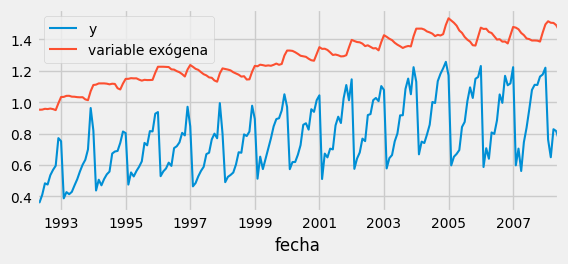

In [ ]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/gustavovazquez/datasets/main/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

fig, ax = plt.subplots(figsize=(6, 2.5))
datos['y'].plot(ax=ax, label='y')
datos['exog_1'].plot(ax=ax, label='variable exógena')
ax.legend();

In [ ]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(
    f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})"
)
print(
    f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})"
)

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


##ForecasterAutoreg

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=datos_train['y'], exog=datos_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['exog_1'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-11-07 17:01:30 
Last fit date: 2025-11-07 17:01:31 
Skforecast version: 0.13.0 
Python version: 3.

## Predicciones
Si el ForecasterAutoreg se entrena con una variable exógena, hay que pasarle el valor de esta variable al ```predict()```. Por lo tanto, solo es aplicable a escenarios en los que se dispone de información a futuro de la variable exógena.

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

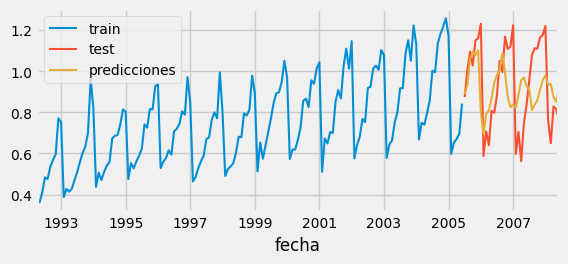

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

## Error de las predicciones en el conjunto de test

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.03989087922533575


## Tuning del modelo

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        exog               = datos_train['exog_1'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                    )

Number of models compared: 27.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.020919321798477056



In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 50}",0.020919,10,50
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 50}",0.021596,5,50
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.021759,5,500
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.021839,3,500
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.021968,10,500


Los mejores resultados se obtienen utilizando una ventana temporal de 12 lags y una configuración de Random Forest {'max_depth': 10, 'n_estimators': 50}.

## Modelo final
Como se ha indicado ```return_best = True``` en ```grid_search_forecaster```, tras la búsqueda, el objeto ```ForecasterAutoreg``` ha sido modificado y entrenado con la mejor combinación encontrada.

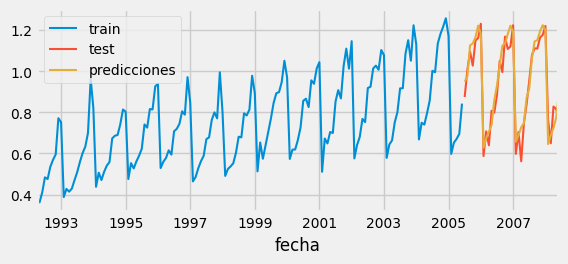

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.0044949967759907675


## Forecasting autorregresivo recursivo con predictores custom
En determinados escenarios, puede ser interesante incorporar otras características de la serie temporal además de los lags, por ejemplo, la media movil de los últimos n valores puede servir para capturar la tendencia de la serie.

La clase ForecasterAutoregCustom se comporta de forma muy similar a la clase ForecasterAutoreg vista en los apartados anteriores pero con la diferencia de que, es el usuario, quien define la función empleada para crear los predictores.

Se repite el primer ejemplo del documento, predecir los últimos 36 meses de la serie temporal, pero esta vez, utilizando como predictores los 10 primeros lags y la media móvil de los últimos 20 meses.